<a href="https://colab.research.google.com/github/rpdahxn/GANsInAction/blob/main/ch02_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.datasets import mnist

In [ ]:
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

샘플링 헬퍼 함수

In [ ]:
def sampling(args: tuple):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

인코더 정의

In [ ]:
# 인코더 입력
x = Input(shape=(original_dim,), name="input")
# 중간층
h = Dense(intermediate_dim, activation='relu', name="encoding")(x)

# 잠재 공간의 평균을 정의
z_mean = Dense(latent_dim, name="mean")(h)
# 잠재 공간의 로그 분산을 정의
z_log_var = Dense(latent_dim, name="log-variance")(h)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

encoder = Model(x, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 784)]        0           []                               
                                                                                                  
 encoding (Dense)               (None, 256)          200960      ['input[0][0]']                  
                                                                                                  
 mean (Dense)                   (None, 2)            514         ['encoding[0][0]']               
                                                                                                  
 log-variance (Dense)           (None, 2)            514         ['encoding[0][0]']               
                                                                                            

디코더 정의

In [ ]:
input_decoder = Input(shape=(latent_dim,), name="decoder_input")
# 잠재 공간을 중간 층의 차원으로 변환
decoder_h = Dense(intermediate_dim, activation='relu', name="decoder_h")(input_decoder)
# getting the mean from the original dimension
x_decoded = Dense(original_dim, activation='sigmoid', name="flat_decoded")(decoder_h)

decoder = Model(input_decoder, x_decoded, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 decoder_h (Dense)           (None, 256)               768       
                                                                 
 flat_decoded (Dense)        (None, 784)               201488    
                                                                 
Total params: 202,256
Trainable params: 202,256
Non-trainable params: 0
_________________________________________________________________


변이형 오토인코더(VAE) 정의

In [ ]:
# 인코더의 세 번째 반환값이 z
output_combined = decoder(encoder(x)[2])
# 입력과 출력을 연결
vae = Model(x, output_combined)
vae.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 2),               201988    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 784)               202256    
                                                                 
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


손실 정의, 모델 실행

In [ ]:
kl_loss = -0.5 * K.sum(
    1 + z_log_var - K.exp(z_log_var) - K.square(z_mean),
    axis=-1)

vae.add_loss(K.mean(kl_loss) / 784.)
vae.compile(optimizer='rmsprop', loss="binary_crossentropy")
vae.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 784)]        0           []                               
                                                                                                  
 encoder (Functional)           [(None, 2),          201988      ['input[0][0]']                  
                                 (None, 2),                                                       
                                 (None, 2)]                                                       
                                                                                                  
 decoder (Functional)           (None, 784)          202256      ['encoder[0][2]']                
                                                                                            

MNIST 데이터셋을 로드하고 전처리까지

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [ ]:
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size)

Epoch 1/50
600/600 [==============================] - 9s 13ms/step - loss: 0.2434
Epoch 2/50
600/600 [==============================] - 8s 14ms/step - loss: 0.2182
Epoch 3/50
600/600 [==============================] - 8s 14ms/step - loss: 0.2129
Epoch 4/50
600/600 [==============================] - 9s 15ms/step - loss: 0.2098
Epoch 5/50
600/600 [==============================] - 9s 15ms/step - loss: 0.2076
Epoch 6/50
600/600 [==============================] - 10s 16ms/step - loss: 0.2057
Epoch 7/50
600/600 [==============================] - 9s 15ms/step - loss: 0.2040
Epoch 8/50
600/600 [==============================] - 14s 24ms/step - loss: 0.2026
Epoch 9/50
600/600 [==============================] - 15s 25ms/step - loss: 0.2015
Epoch 10/50
600/600 [==============================] - 13s 21ms/step - loss: 0.2005
Epoch 11/50
600/600 [==============================] - 12s 20ms/step - loss: 0.1997
Epoch 12/50
600/600 [==============================] - 13s 21ms/step - loss: 0.1991
Epoch 1

모델을 사용해 데이터를 생성한다.

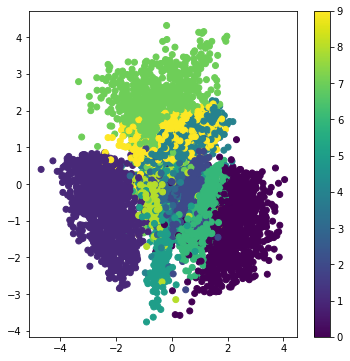

In [ ]:
# 잠재 공간에 투영된 숫자 클래스의 2D 그래프
x_test_encoded = encoder.predict(x_test, batch_size = batch_size)[0]
plt.figure(figsize = (6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c = y_test, cmap = 'viridis')
plt.colorbar()
plt.show()

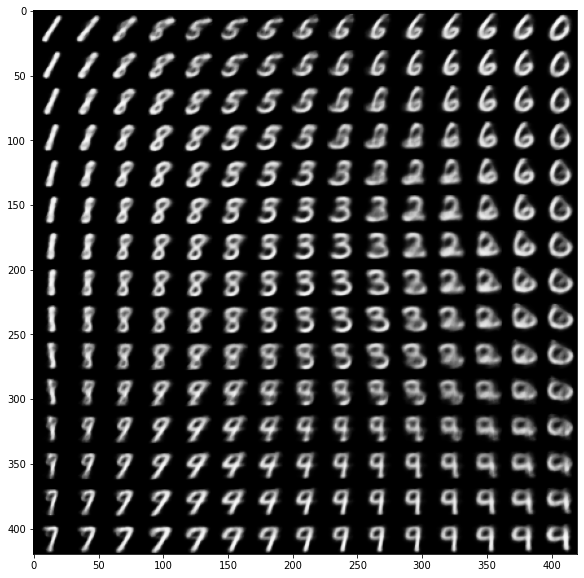

In [ ]:
# 숫자의 2D 매니폴드 출력하기
n = 15  # 15x15 숫자를 담은 그림
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# 잠재 공간을 가우스 분포로 가정했기 때문에 잠재 변수 z의 값을 만들기 위해
# 일정 간격으로 떨어진 좌표를 가우스 분포의 역 CDF(ppf)를 통해 변환합니다.
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()